In [41]:
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import os
import seaborn as sns

# Unzip KO terms
zip_file_path_KO = 'terms_KO.zip'
csv_file_name_KO = 'terms_KO.csv'

# Unzip reduced dataset
zip_file_path = 'reducedDataset.zip'
csv_file_name = 'reducedDataset.csv'

In [42]:
# Reads and processes KO terms
with zipfile.ZipFile(zip_file_path_KO, 'r') as z:
    with z.open(csv_file_name_KO) as file:
        KOs = pd.read_csv(file, index_col=0)

KOs['value'] = 1
X_terms = KOs.pivot_table(index='key', columns='KO', values='value', fill_value=0)

# Apply VarianceThreshold to remove constant features
selector = VarianceThreshold(threshold=0)
X_filtered = selector.fit_transform(X_terms)
X_filtered_df = pd.DataFrame(X_filtered, index=X_terms.index, columns=X_terms.columns[selector.get_support()])


In [43]:
# Processes data for traits
with zipfile.ZipFile(zip_file_path, 'r') as zip:
    with zip.open(csv_file_name) as file:
        traits = pd.read_csv(file, sep=';')
traits['oxygen'] = traits['oxygen'].str.lower()


In [44]:
# Mapping of oxygen levels to a simplified classification
oxygen_mapping = {
    'aerobic': 'aerobic',
    'aerotolerant': 'aerobic',
    'microaerophilic': 'aerobic',
    'obligate aerobic': 'aerobic',
    'anaerobic': 'anaerobic',
    'obligate anaerobic': 'anaerobic',
    'conflict': 'aerobic',  # This should be checked
    'facultative': 'aerobic'  # This should also be checked
}
traits['oxygen'] = traits['oxygen'].map(oxygen_mapping)


In [45]:
# Handling missing values and aggregating by key
y = traits.dropna(subset=['oxygen']).groupby('key').agg({'oxygen': lambda x: x.value_counts().index[0]})

# Find common keys after removing missing values
common_keys = X_filtered_df.index.intersection(y.index)

# Align X (features) and Y (labels) based on common keys
X_aligned = X_filtered_df.loc[common_keys]
Y_aligned = y.loc[common_keys].values.ravel()

# Ensures X_aligned and Y_aligned are aligned
assert X_aligned.shape[0] == len(Y_aligned), "X and Y are not aligned"


In [46]:
# Feature Selection: Optimize 'k' based on model performance
select_k = SelectKBest(f_classif, k=20)  # Adjust 'k' based on experimentation
X_new = select_k.fit_transform(X_aligned, Y_aligned)

C:\Users\eliah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 655 1950 2156 2834 4079 4814 5521 5579 5798 6130 6230 8525 8571 8848] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\eliah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [47]:
# Hyperparameter tuning using Grid Search with Cross-Validation
parameters = {'kernel': ('linear', 'rbf'), 'C': [1, 10]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(X_new, Y_aligned)  # Fit on the entire dataset to find the best parameters

print("Best parameters found:", clf.best_params_)


Best parameters found: {'C': 1, 'kernel': 'rbf'}


In [52]:
# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y_aligned, test_size=0.4, random_state=42)

# Refitting the model with best parameters on the training set
clf_best = svm.SVC(kernel=clf.best_params_['kernel'], C=clf.best_params_['C'])
clf_best.fit(X_train, Y_train)

# Evaluate model on the test set and prediciting
Y_pred = clf_best.predict(X_test)
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("Precision:", precision_score(Y_test, Y_pred, average='macro'))
print("Recall:", recall_score(Y_test, Y_pred, average='macro'))
print("F1-Score:", f1_score(Y_test, Y_pred, average='macro'))
# Classification Report
class_report = classification_report(Y_test, Y_pred)
print("Classification Report:\n", class_report)


Accuracy: 0.9516500383729855
Precision: 0.9387734746801174
Recall: 0.8849538715403655
F1-Score: 0.9090068669670619
Classification Report:
               precision    recall  f1-score   support

     aerobic       0.96      0.99      0.97      1081
   anaerobic       0.92      0.78      0.85       222

    accuracy                           0.95      1303
   macro avg       0.94      0.88      0.91      1303
weighted avg       0.95      0.95      0.95      1303



Confusion matrix, without normalization
[[1071   10]
 [  55  167]]
Normalized confusion matrix
[[0.99074931 0.00925069]
 [0.24774775 0.75225225]]


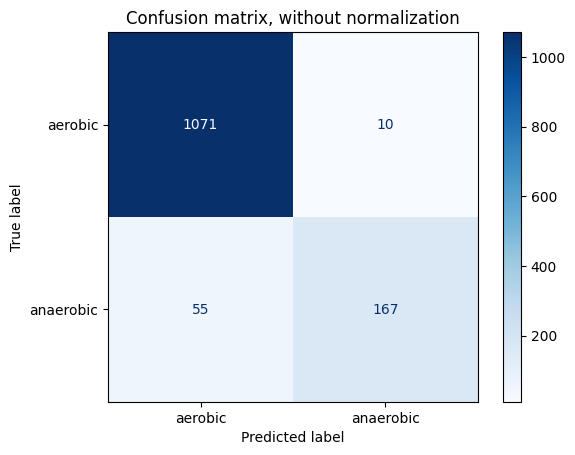

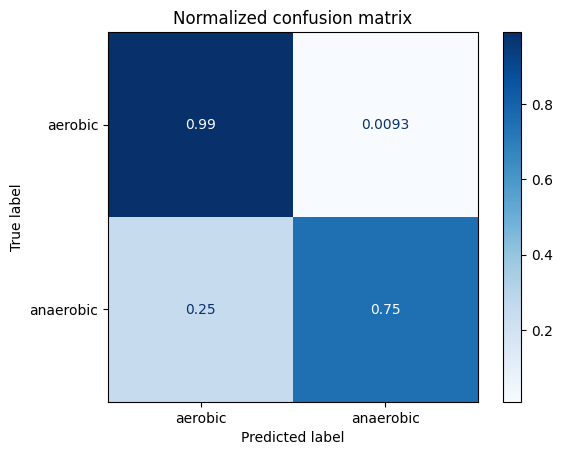

In [49]:
# Confusion Matrix Display
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        clf_best,
        X_test,
        Y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

plt.show()

In [51]:
from sklearn.feature_selection import SelectKBest, f_classif

# Assuming X_norm and Y are your normalized features and labels respectively
select_k_best = SelectKBest(f_classif, k=20)  # Adjust k as needed
X_new = select_k_best.fit_transform(X_norm, Y)
selected_features = select_k_best.get_support(indices=True)

# Get the names of the selected KO terms
selected_ko_terms = X.columns[selected_features]

print("Selected KO terms for predicting oxygen trait:")
print(selected_ko_terms)

Selected KO terms for predicting oxygen trait:
Index(['K00164', 'K00176', 'K00254', 'K00940', 'K01163', 'K01589', 'K01599',
       'K01677', 'K01679', 'K01772', 'K02257', 'K02259', 'K02823', 'K04070',
       'K05919', 'K07138', 'K11358', 'K13628', 'K16951', 'K17828'],
      dtype='object', name='KO')


C:\Users\eliah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 655 1950 2156 2834 4079 4814 5521 5579 5798 6130 6230 8525 8571 8848] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\eliah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
